## RT prediction using transfer learning with AutoRT

In this notebook, I will walk you through an example about transfer learning in AutoRT for accurate RT prediction using a small training data (5141 peptides). This is how users should use AutoRT in most cases.If there are variable modifications other than Oxidation on M in your dataset, you have to retrain the base model used by AutoRT in transfer learning.

### Installation

In [149]:
## install cuda library for tensorflow 2.5
! conda install cudatoolkit=11.2
! conda install -c fastchan cudnn=8.1.0.77

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [165]:
## install AutoRT
! git clone https://github.com/bzhanglab/AutoRT
! ls -l -t
! pip install -r AutoRT/requirements.txt

Cloning into 'AutoRT'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 233 (delta 41), reused 24 (delta 12), pack-reused 148
Receiving objects: 100% (233/233), 590.92 MiB | 61.52 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Checking out files: 100% (41/41), done.
total 4
drwxr-xr-x 6 bw10 zhanglab 4096 Aug 19 16:06 AutoRT


### Example dataset

In this example, we will use a dataset used in the original AutoRT paper. It is from a label free dataset and all the peptides are from a single fraction. For MS/MS searching, a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M) were used. Since all C amino acids were modified, we don't need to encode modified C in AutoRT. For amino acid M, there should have two versions in the dataset, so we need to encode modified M and unmodified M. We use "M" to represent unmodified M and use "1" to represent modified M (Oxidation [M]).This should be consistent with the encoding for modifications in the training data used for base models.

The example data is in the folder **AutoRT/example/**: data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv

Go to the folder **AutoRT/example/**:

In [151]:
## go to the folder example
%cd AutoRT/example/

/data/wenbo/test/AutoRT/example


Check all the data in the foler **AutoRT/example/**:

In [152]:
! ls -l

total 12
drwxr-xr-x 2 bw10 zhanglab 4096 Aug 19 15:48 data
-rw-r--r-- 1 bw10 zhanglab  385 Aug 19 15:48 train_model_from_scratch.sh
-rw-r--r-- 1 bw10 zhanglab  362 Aug 19 15:48 transfer_learning.sh


In [153]:
import pandas as pd
train_data = pd.read_csv("data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv",sep="\t")
print("The number of unique peptides in the training data: %d" % (train_data.shape[0]))
train_data.head()

The number of unique peptides in the training data: 5141


,x,y
0,1APYQGPDAVPGALDYK,37.797092
1,1CCCSYNIGR,18.298540
2,1CFNYEIR,28.325425
3,1FLGDNAHLSIINEYLSQSYQK,61.661926
4,1GYAEEAPYDAIHVGAAAPVVPQALIDQLKPGGR,64.956116


RT distribution in the training data is shown below. The unit of the RT in the data is minute.

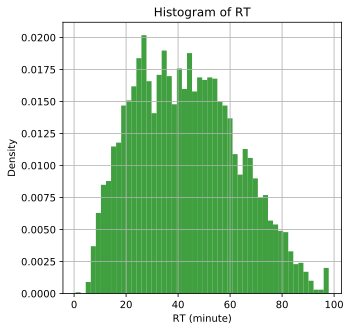

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# the histogram of the data
plt.hist(train_data['y'], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('RT (minute)')
plt.ylabel('Density')
plt.title('Histogram of RT')
plt.grid(True)
plt.show()


### Training


#### Base model:
The trained base model used here is available at **AutoRT/models/base_models_PXD006109/**. The base model was trained using a large dataset which contains more than 100,000 peptides.The training data for the base model training only contains a fixed modification of Carbamidomethyl (C) and a variable modifications of Oxidation (M).We encoded modified M (Oxidation) using "1".

#### Experiment-specific RT model training:
Below is the command line for training using transfer learning strategy.


In [155]:
! python ../autort.py train -i data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_train.tsv -o tf_model/ -e 40 -b 64 -u m -m ../models/base_models_PXD006109/model.json -rlr -n 10

2021-08-19 15:48:43.904022: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Scaling method: min_max
Transfer learning ...

Deep learning model: 0
Load aa coding data from file ../models/base_models_PXD006109/aa.tsv
AA types: 21
Longest peptide in training data: 41

Use test file tf_model//validation.tsv
Longest peptide in test data: 30

['1', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
RT range: 0 - 98

X_train shape:
(4626, 48, 21)
X_test shape:
(515, 48, 21)
Modeling start ...
2021-08-19 15:48:45.773826: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-19 15:48:45.826699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN Xp COLLECTORS EDITION computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemo

After the training is done, the trained model is in the folder **tf_model/** (-o):

In [156]:
! ls -l tf_model/

total 342620
-rw-r--r-- 1 bw10 zhanglab      100 Aug 19 15:57 aa.tsv
-rw-r--r-- 1 bw10 zhanglab 16077440 Aug 19 15:57 best_model.hdf5
-rw-r--r-- 1 bw10 zhanglab 40557968 Aug 19 15:49 model_0.h5
-rw-r--r-- 1 bw10 zhanglab 36550464 Aug 19 15:50 model_1.h5
-rw-r--r-- 1 bw10 zhanglab 37936544 Aug 19 15:51 model_2.h5
-rw-r--r-- 1 bw10 zhanglab 17440696 Aug 19 15:52 model_3.h5
-rw-r--r-- 1 bw10 zhanglab 35733760 Aug 19 15:53 model_4.h5
-rw-r--r-- 1 bw10 zhanglab 51615344 Aug 19 15:54 model_5.h5
-rw-r--r-- 1 bw10 zhanglab 40557968 Aug 19 15:55 model_6.h5
-rw-r--r-- 1 bw10 zhanglab 26949600 Aug 19 15:56 model_7.h5
-rw-r--r-- 1 bw10 zhanglab 30836848 Aug 19 15:57 model_8.h5
-rw-r--r-- 1 bw10 zhanglab 16076408 Aug 19 15:57 model_9.h5
-rw-r--r-- 1 bw10 zhanglab      440 Aug 19 15:57 model_all.json
-rw-r--r-- 1 bw10 zhanglab      506 Aug 19 15:59 model.json
-rw-r--r-- 1 bw10 zhanglab   112048 Aug 19 15:59 models_combination_metrics.tsv
-rw-r--r-- 1 bw10 zhanglab    15269 Aug 19 15:57 test_0.csv
-r

### Prediction

There is a testing dataset in the same folder **AutoRT/example/**:data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv.

The column **x** is required which contains the peptides. The column "y" is not required.

In [157]:
test_data = pd.read_csv("data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv",sep="\t")
test_data.head()

,x,y
0,LINNNPEIFGPLK,46.334335
1,VGDTYERPK,11.445240
2,TSRPENAIIYNNNEDFQVGQAK,33.492008
3,KQNVVPTVLALGSDVD1DVLTTLSLGDR,83.955305
4,IVASTLSNPELFEEWTGNVK,64.316923


In [158]:
! python ../autort.py predict -t data/28CPTAC_COprospective_W_VU_20150810_05CO037_f01_normal_test.tsv -s tf_model/model.json -o tf_prediction/ -p test

2021-08-19 15:59:03.754636: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Average ...
Load aa coding data from file tf_model/aa.tsv
AA types: 21
Longest peptide in input data: 35

['1', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

Deep learning model: 0

Deep learning model: 1

Deep learning model: 2
2021-08-19 15:59:05.133474: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-19 15:59:05.194871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA TITAN Xp COLLECTORS EDITION computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2021-08-19 15:59:05.195332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 

The prediction result is in the file **tf_prediction/test.tsv**. The values in the column **y_pred** are predicted RT. Other files in the same folder are intermediate files which are not useful to users. 

In [159]:
! ls -l tf_prediction/

total 124
-rw-r--r-- 1 bw10 zhanglab 16940 Aug 19 15:59 test_2.csv
-rw-r--r-- 1 bw10 zhanglab 16952 Aug 19 15:59 test_4.csv
-rw-r--r-- 1 bw10 zhanglab 16944 Aug 19 15:59 test_5.csv
-rw-r--r-- 1 bw10 zhanglab 16927 Aug 19 15:59 test_9.csv
-rw-r--r-- 1 bw10 zhanglab 16733 Aug 19 15:59 test_evaluate.csv
-rw-r--r-- 1 bw10 zhanglab 23279 Aug 19 15:59 test.tsv


Now we can look at the performance of the RT prediction.

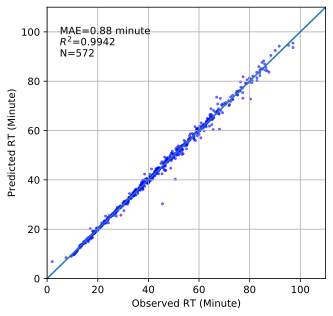

In [160]:
import sklearn
import scipy
from sklearn.model_selection import train_test_split


pred_data = pd.read_csv("tf_prediction/test.tsv",sep="\t")
pred_data.head()

cor = scipy.stats.pearsonr(pred_data['y'], pred_data['y_pred'])[0]
mae = sklearn.metrics.mean_absolute_error(pred_data['y'], pred_data['y_pred'])
r2 = sklearn.metrics.r2_score(pred_data['y'], pred_data['y_pred'])

plt.rcParams['figure.figsize'] = [5, 5]
plt.scatter(pred_data['y'], pred_data['y_pred'],s=4, c="blue", alpha=0.5)
plt.text(5, 90, "MAE="+"{:.2f}".format(mae)+" minute\n$R^2$="+"{:.4f}".format(r2)+"\nN="+str(pred_data.shape[0]))
plt.plot( [0,110],[0,110] )
plt.xlabel('Observed RT (Minute)')
plt.ylabel('Predicted RT (Minute)')
plt.xlim(0,110)
plt.ylim(0,110)
plt.grid(True)
plt.show()